# Assignment 1: Data Prep & Analysis - kelvin.ahiakpor

### Imports

In [14]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re

### Web Scraping

In [15]:
url = 'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States'

page = requests.get(url)

soup = BeautifulSoup(page.text, 'html')

In [16]:
table = soup.find('table')

#print(table)
#soup.find_all('th')[:7]

##### Getting the column headings from soup as a list

In [17]:
#Getting the column headings from soup as a list
presidential_entities = soup.find_all('th')[:7] #pick only the first 7 headers. the rest do not belong in the table

presidential_entities = [entity.text.strip() for entity in presidential_entities]

##### Cleaning column names using regular expressions

In [18]:
#remove citation superscripts in square brackets
presidential_entities = [re.sub(r'\[.*?\]', '', entity) for entity in presidential_entities] 

#remove Birth-Death string
presidential_entities = [re.sub(r'\(Birth–Death\)', '', entity) for entity in presidential_entities] 

#exclude Portrait table column heading
presidential_entities = [entity for entity in presidential_entities if entity != 'Portrait'] 

presidential_entities

['No.', 'Name', 'Term', 'Party', 'Election', 'Vice President']

### Creating the dataframe

#### df is the dataframe that will be atomized further to answer the questions
#### df2 is the dataframe that contains the exact table data from wikipedia

In [19]:
df = pd.DataFrame(columns = presidential_entities) #creating dataframe using presidential entity list as columns

df2 = df.copy() #creating dataframe using presidential entity list as columns

### Populating the dataframe

In [20]:
column_data = table.find_all('tr') #find table row tags

In [21]:
#df = pd.DataFrame(columns = presidential_entities)
#column_data = table.find_all('tr') #find table row tags
#for row in column_data[1:]:
#    row_data = row.find_all('td')
#    individual_rows = [data.text.strip() for data in row_data]
#    print(individual_rows)
#.   length = len(df)
#    df.loc[length] = individual_rows

##### Adding rows from the soup to the data frame and cleaning data with regular expresions and string methods using a loop

In [22]:
for i,row in enumerate(column_data[1:]): #skip the ['1']
    row_data = row.find_all('td')[1:]
    individual_rows = [data.text.strip() for data in row_data]
    individual_rows = [re.sub(r'\[.*?\]', '', row) for row in individual_rows] #remove superscripts on names
    individual_rows = [row for row in individual_rows if row] #list-comprehension syntax to remove empty strings
    individual_rows = [row.replace('\n\n', ' & ') for row in individual_rows] #placing & between multiple election years
    individual_rows = [re.sub(r'– &', '', row) for row in individual_rows] #remove - & from single election years
    individual_rows = [row.replace('\xa0', ' ') for row in individual_rows]  #replacing non-breaking space with regular space
    individual_rows = [row.replace('\n', ' ') for row in individual_rows] #placing & between multiple election years
    individual_rows = [re.sub(r'Vacant after[^\&]*', '', row) for row in individual_rows]  # clean Vacant after from Vice President
    individual_rows = [re.sub(r'Vacant throughout[^\&]*', '', row) for row in individual_rows]  # clean Vacant throughout
    individual_rows = [re.sub(r'Vacant through[^\&]*', '', row) for row in individual_rows]  # clean Vacant through
    individual_rows = [re.sub(r'Vacant:[^&]*', '', cell) for cell in individual_rows]  # Vacant:<date range>
    individual_rows = [re.sub(r' & & ', ' & ', row) for row in individual_rows] #remove & & replace w &
    individual_rows = [re.sub(r'^\s*&\s*', '', row) for row in individual_rows]  # remove & from the start vp name
    individual_rows = [re.sub(r'\s*&\s*$', '', row) for row in individual_rows]  # Remove & from the end of vp names
    individual_rows.insert(0, str(i+1)) #enumerating the rows by inserting their count number in the array
    
    #print(individual_rows)
    
    length = len(df)
    
    df.loc[length] = individual_rows
    df2.loc[length] = individual_rows #or df2 = df.copy() in outer indent

##### Further data cleaning and pre-processing for Question 5

In [23]:
#df = df2.copy() #prevents errors when this cell is run multiple times. otherwise comment out

#create new column with Birth and Death Years
birth_death_years = df['Name'].str.extract(r'\((\d{4})–(\d{4})\)')
df[['Birth Year', 'Death Year']] = birth_death_years


#edit NaN values in birthyear with presidents who are alive. Use[0] to extract and pass series to fill na.
birth_years = df['Name'].str.extract(r'\(b\. (\d{4})\)')[0]
df['Birth Year'] = df['Birth Year'].fillna(birth_years)

#remove birth death information from Name series
df['Name'] = df['Name'].str.replace(r'\(\d{4}–\d{4}\)', '', regex=True) #raw string pattern for (1913–2006)
df['Name'] = df['Name'].str.replace(r'\(b\. \d{4}\)', '', regex=True) #raw string pattern for (b. 1942)

df2['Name'] = df2['Name'].str.replace(r'\(\d{4}–\d{4}\)', '', regex=True) #raw string pattern for (1913–2006)
df2['Name'] = df2['Name'].str.replace(r'\(b\. \d{4}\)', '', regex=True) #raw string pattern for (b. 1942)


#extract date in and date out from term column. drop term column
df[['Date In', 'Date Out']] = df['Term'].str.split('–', expand=True)
df.drop('Term', axis = 1, inplace = True)

# convert date columns to datetime using pandas. coerce to handle non date elements
df['Date In'] = pd.to_datetime(df['Date In'], errors='coerce')
df['Date Out'] = pd.to_datetime(df['Date Out'], errors='coerce')

# Question 1
Web Scraping

In [24]:
df2

,No.,Name,Term,Party,Election,Vice President
0,1,George Washington,"April 30, 1789–March 4, 1797",Unaffiliated,1788–1789 & 1792,John Adams
1,2,John Adams,"March 4, 1797–March 4, 1801",Federalist,1796,Thomas Jefferson
2,3,Thomas Jefferson,"March 4, 1801–March 4, 1809",Democratic-Republican,1800 & 1804,Aaron Burr & George Clinton
3,4,James Madison,"March 4, 1809–March 4, 1817",Democratic-Republican,1808 & 1812,George Clinton & Elbridge Gerry
4,5,James Monroe,"March 4, 1817–March 4, 1825",Democratic-Republican,1816 & 1820,Daniel D. Tompkins
5,6,John Quincy Adams,"March 4, 1825–March 4, 1829",Democratic-Republican & National Republican,1824,John C. Calhoun
6,7,Andrew Jackson,"March 4, 1829–March 4, 1837",Democratic,1828 & 1832,John C. Calhoun & Martin Van Buren
7,8,Martin Van Buren,"March 4, 1837–March 4, 1841",Democratic,1836,Richard Mentor Johnson
8,9,William Henry Harrison,"March 4, 1841–April 4, 1841",Whig,1840,John Tyler
9,10,John Tyler,"April 4, 1841–March 4, 1845",Whig & Unaffiliated,–,


# Question 2
Number of presidents

In [25]:
num_presidents = df['Name'].nunique()
num_presidents 

45

# Question 3
Number of presidencies

In [26]:
num_presidencies = df['No.'].nunique()
num_presidencies 

46

# Question 4
Presidents who served more than 1 term with the same vice president

In [27]:
for index, row in df2.iterrows():
    p = row['Name']
    election = row['Election']
    term = row['Term']
    vp = row['Vice President']
    
    # check if the president served more than 1 term and had the same vice president
    if '&' in election and '&' not in vp:
        print(f"{p} had served more than 1 term: {term} with one vice: {vp}\n")

George Washington had served more than 1 term: April 30, 1789–March 4, 1797 with one vice: John Adams

James Monroe had served more than 1 term: March 4, 1817–March 4, 1825 with one vice: Daniel D. Tompkins

Woodrow Wilson had served more than 1 term: March 4, 1913–March 4, 1921 with one vice: Thomas R. Marshall

Dwight D. Eisenhower had served more than 1 term: January 20, 1953–January 20, 1961 with one vice: Richard Nixon

Ronald Reagan had served more than 1 term: January 20, 1981–January 20, 1989 with one vice: George H. W. Bush

Bill Clinton had served more than 1 term: January 20, 1993–January 20, 2001 with one vice: Al Gore

George W. Bush had served more than 1 term: January 20, 2001–January 20, 2009 with one vice: Dick Cheney

Barack Obama had served more than 1 term: January 20, 2009–January 20, 2017 with one vice: Joe Biden



In [48]:
duration = (df['Date Out'] - df['Date In']).dt.days

for index, row in df.iterrows():
    p = row['Name']
    election = row['Election']
    term = df2['Term'].iloc[index]
    vp = row['Vice President']
    time = duration[index] 
    
    # Check if the president served more than 1 term (duration > 1461 days) and had only one vice president
    if time > 1461 and '&' not in vp:
        print(f"{p} had served more than 1 term: {term} days with one vice president: {vp}\n")

George Washington had served more than 1 term: April 30, 1789–March 4, 1797 days with one vice president: John Adams

James Monroe had served more than 1 term: March 4, 1817–March 4, 1825 days with one vice president: Daniel D. Tompkins

Theodore Roosevelt had served more than 1 term: September 14, 1901–March 4, 1909 days with one vice president: Charles W. Fairbanks

Woodrow Wilson had served more than 1 term: March 4, 1913–March 4, 1921 days with one vice president: Thomas R. Marshall

Calvin Coolidge had served more than 1 term: August 2, 1923–March 4, 1929 days with one vice president: Charles G. Dawes

Harry S. Truman had served more than 1 term: April 12, 1945–January 20, 1953 days with one vice president: Alben W. Barkley

Dwight D. Eisenhower had served more than 1 term: January 20, 1953–January 20, 1961 days with one vice president: Richard Nixon

Lyndon B. Johnson had served more than 1 term: November 22, 1963–January 20, 1969 days with one vice president: Hubert Humphrey

Ro

# Question 5
President with the longest term

In [28]:
service_duration = df['Date Out'].dt.year - df['Date In'].dt.year #create standalone series with service durations
longest_serving_president = df.loc[service_duration.idxmax()] #return index of max duration into loc to return row
print(f"The longest serving president was {longest_serving_president['Name']}, " + 
      f"he served {int((service_duration.iloc[service_duration.idxmax()])/4)} terms " +
      f"and entered office in {df['Date In'].dt.date.iloc[service_duration.idxmax()]}. \n" + 
      f"He went into office {df['Election'].iloc[service_duration.idxmax()]}. "+
      f"If he had not died in 1945, he would have served his 4th term.")

The longest serving president was Franklin D. Roosevelt, he served 3 terms and entered office in 1933-03-04. 
He went into office 1932 & 1936 &  1940 &  1944. If he had not died in 1945, he would have served his 4th term.


# Question 6
Presidents who served as vice presidents

In [45]:
vice_presidents = []
# iterate over each row in the Vice President Series
for vp in df['Vice President'].dropna(): #ignore null entries
    # split the vp string by & and append each name to the list
    for name in vp.split('&'):
        vice_presidents.append(name.strip()) #remove trailing and leading whitespaces
    
presidents = []
# iterate over each row in the President Series
for p in df['Name']:
    # split the string by & and append each name to the list
    presidents.append(p.strip()) #remove trailing and leading whitespaces
    
vps_to_presidents = []

for vp in vice_presidents:
    if vp in presidents:
        vps_to_presidents.append(vp)
        
#df2['Term'].iloc[df2.index[df2['Name'] == 'John Adams']].iloc[0] #last iloc[0] is very important
presidency_service = [df2['Term'].iloc[df2.index[df2['Name'] == name]].iloc[0] for name in vps_to_presidents]

#vp_service = [df2['Term'].iloc[df2.index[df2['Vice President'] == name]].iloc[0] for name in vps_to_presidents]
vp_service = []

for name in vps_to_presidents:
    #using boolean indexing for series to filter rows that have the current vp name in the VP column
    #boolean condition
    is_name_in_vp_column = df2['Vice President'].str.contains(name, na=False)
    filtered_rows = df2[is_name_in_vp_column] #boolean series
    
    if not filtered_rows.empty:
        term = filtered_rows['Term'].iloc[0]
        vp_service.append(term)
        
#print(f'Presidents who were vice presidents: {", ".join(vps_to_presidents)}')
print(f'Presidents who were vice presidents.')

for vp, vp_period, p_period in zip(vps_to_presidents,vp_service,presidency_service):
    print(vp + " served as vice from " + vp_period + " and served presidency from " + p_period +".\n")

    
#presidency_service 
#vp_service

#df2['Term'].iloc[df2.index[df2['Vice President'] == 'John Adams']].iloc[0]
#this causes an error hence the need for the longer for loop
#df2['Term'].iloc[df2.index[df2['Vice President'] == 'Gerald Ford']].iloc[0] 

Presidents who were vice presidents.
John Adams served as vice from April 30, 1789–March 4, 1797 and served presidency from March 4, 1797–March 4, 1801.

Thomas Jefferson served as vice from March 4, 1797–March 4, 1801 and served presidency from March 4, 1801–March 4, 1809.

Martin Van Buren served as vice from March 4, 1829–March 4, 1837 and served presidency from March 4, 1837–March 4, 1841.

John Tyler served as vice from March 4, 1841–April 4, 1841 and served presidency from April 4, 1841–March 4, 1845.

Millard Fillmore served as vice from March 4, 1849–July 9, 1850 and served presidency from July 9, 1850–March 4, 1853.

Andrew Johnson served as vice from March 4, 1861–April 15, 1865 and served presidency from April 15, 1865–March 4, 1869.

Chester A. Arthur served as vice from March 4, 1881–September 19, 1881 and served presidency from September 19, 1881–March 4, 1885.

Theodore Roosevelt served as vice from March 4, 1897–September 14, 1901 and served presidency from September 14

# Question 7
Presidents who were never elected

In [30]:
count = 0
for index, row in df2.iterrows():
    prez = row['Name']
    term = row['Term']
    if row['Election'] == '–':
        count += 1
        print(f"{prez} was never elected. However, his term was from {term}.\n")
print(f"In total, {count} presidents were never elected.")

John Tyler was never elected. However, his term was from April 4, 1841–March 4, 1845.

Millard Fillmore was never elected. However, his term was from July 9, 1850–March 4, 1853.

Andrew Johnson was never elected. However, his term was from April 15, 1865–March 4, 1869.

Chester A. Arthur was never elected. However, his term was from September 19, 1881–March 4, 1885.

Gerald Ford was never elected. However, his term was from August 9, 1974–January 20, 1977.

In total, 5 presidents were never elected.


# Question 8
Presidents who have the same forenames or surnames

In [31]:
#create list of all names
full_names = df['Name'].tolist()
#full_names = [name for name in full_names if full_names.count(name) < 2] #remove the duplicate
#full_names = [name[0]+name[-1] for name.split(':') in full_names]
for i, name in enumerate(full_names):
    names_list = name.split(' ')
    full_names[i] = str(i) + ' ' + names_list[0]+ ' ' +names_list[-1]

#create histogram dictionary of forenames
forenames = {} #president name histogram
forenames_list = {}
for prez in full_names:
    forenames[prez.split(' ')[1]] = forenames.get(prez.split(' ')[1],0)+1
    forenames_list[prez.split(' ')[0]] = prez.split(' ')[1]
    #same_first_names
    
#create histogram dictionary of surnames
surnames = {} #president name histogram
surnames_list = {}
for prez in full_names:
    surnames[prez.split(' ')[2]] = surnames.get(prez.split(' ')[2],0)+1
    surnames_list[prez.split(' ')[0]] = prez.split(' ')[2]
    
#create list of same forenames
#same_forename_count = 0
same_forenames = []
same_forenames_idx = []
for i in forenames:
    if forenames[i]>1:
        #same_forename_count += forenames[i]
        same_forenames.append(i)
        #print(i)
        for index in forenames_list:
            if forenames_list[index] == i:
                same_forenames_idx.append(int(index))


#print(same_forenames)   
#print(same_forenames_idx) 
#print('')

#create list of same surnames
#same_surname_count = 0
same_surnames = []
same_surnames_idx = []
for i in surnames:
    if surnames[i]>1:
        #same_surname_count += surnames[i]
        same_surnames.append(i)
        #print(i)
        for index in surnames_list:
            if surnames_list[index] == i:
                same_surnames_idx.append(int(index))
                
#print(same_surnames)  
#print(same_surnames_idx) 

# for i in same_forenames:
#     print(df['Name'].iloc[df.index[df['Name'] == name]].iloc[0] for name in forenames_list)

same_forenames = [df['Name'].iloc[idx] for idx in same_forenames_idx]
same_surnames = [df['Name'].iloc[idx] for idx in same_surnames_idx]

# converting the lists to a set to remove duplicates (Grover Cleveland) then back to a list
same_forenames = list(set(same_forenames))
same_surnames = list(set(same_surnames))

print("These are the names of presidents with the same forenames and when they served in office\n")
for i,name in enumerate(same_forenames):
    print(name + ' ||| served from ' + df2['Term'].iloc[same_forenames_idx[i]])
    
print('')

print("These are the names of presidents with the same surnames and when they served in office\n")
for i,name in enumerate(same_surnames):
    print(name + ' ||| served from ' + df2['Term'].iloc[same_surnames_idx[i]])
    

These are the names of presidents with the same forenames and when they served in office

James Buchanan ||| served from April 30, 1789–March 4, 1797
James A. Garfield ||| served from January 20, 1989–January 20, 1993
John F. Kennedy ||| served from January 20, 2001–January 20, 2009
Franklin D. Roosevelt ||| served from March 4, 1797–March 4, 1801
James K. Polk ||| served from March 4, 1825–March 4, 1829
William McKinley ||| served from April 4, 1841–March 4, 1845
William Henry Harrison ||| served from January 20, 1961–November 22, 1963
James Madison ||| served from March 4, 1809–March 4, 1817
John Quincy Adams ||| served from March 4, 1817–March 4, 1825
Grover Cleveland ||| served from March 4, 1845–March 4, 1849
Andrew Jackson ||| served from March 4, 1857–March 4, 1861
George W. Bush ||| served from March 4, 1881–September 19, 1881
John Adams ||| served from March 4, 1829–March 4, 1837
Andrew Johnson ||| served from April 15, 1865–March 4, 1869
George Washington ||| served from Marc

# Question 9
Oldest president ever elected for office

In [71]:
from datetime import datetime
year_in = df['Date In'].dt.year
birth_year = pd.to_datetime(df['Birth Year'],format='%Y').dt.year
oldest_index = (year_in - birth_year).idxmax()

#creating a new data frame to verify result of index 45
df_election_age = pd.DataFrame({'Date In': year_in, 'Birth Year': birth_year})
df_election_age['Election Age'] = year_in - birth_year

print(f"{df['Name'].iloc[oldest_index]} is the oldest president ever elected for office, " +
      f"he got in office {df['Date In'].dt.year.iloc[oldest_index]}, " +
      f"he ended {df['Date Out'].dt.date.iloc[oldest_index] if pd.notna(df['Date Out'].iloc[oldest_index]) else 'not yet'} and his tenure lasted " + 
      f"{df['Date Out'].dt.year.iloc[oldest_index] - df['Date In'].dt.year.iloc[oldest_index] if pd.notna(df['Date Out'].iloc[oldest_index]) else (datetime.now().year-year_in.iloc[oldest_index])} years")

Joe Biden is the oldest president ever elected for office, he got in office 2021, he ended not yet and his tenure lasted 3 years


# Question 10
Youngest president ever elected for office

In [33]:
year_in = df['Date In'].dt.year
birth_year = pd.to_datetime(df['Birth Year'],format='%Y').dt.year
youngest_index = (year_in - birth_year).idxmin() #this equals 25

print(f"{df['Name'].iloc[youngest_index]} is the youngest president ever elected for office, " +
      f"he got in office {df['Date In'].dt.year.iloc[youngest_index]}, " +
      f"he ended {int(df['Date Out'].dt.year.iloc[youngest_index])} and his tenure lasted " + 
      f"{int(df['Date Out'].dt.year.iloc[youngest_index]-df['Date In'].dt.year.iloc[youngest_index])} years")

Theodore Roosevelt is the youngest president ever elected for office, he got in office 1901, he ended 1909 and his tenure lasted 8 years


# Question 11
President who lived very long after leaving office

In [34]:
year_out = df['Date Out'].dt.year
death_year = pd.to_datetime(df['Death Year'],format='%Y').dt.year
longest_living = (death_year - year_out).idxmax()

#creating a new data frame to verify result of index 8
# df_longevity = pd.DataFrame({'Date Out': year_out, 'Death Year': death_year})
# df_longevity['Years Lived After Office'] = death_year - year_out
# df_longevity

print(f"{df['Name'].iloc[longest_living]} is the president who lived longest after leaving office, " +
      f"he left office on {df['Date Out'].dt.date.iloc[longest_living]}, " +
      f"he was alive for {int((death_year - year_out).iloc[longest_living])} years after leaving office.")

Herbert Hoover is the president who lived longest after leaving office, he left office on 1933-03-04, he was alive for 31 years after leaving office.


# Question 12
Graph of political party against number of presidents elected

The party with the most presidents is the Republican party with 18 presidents elected


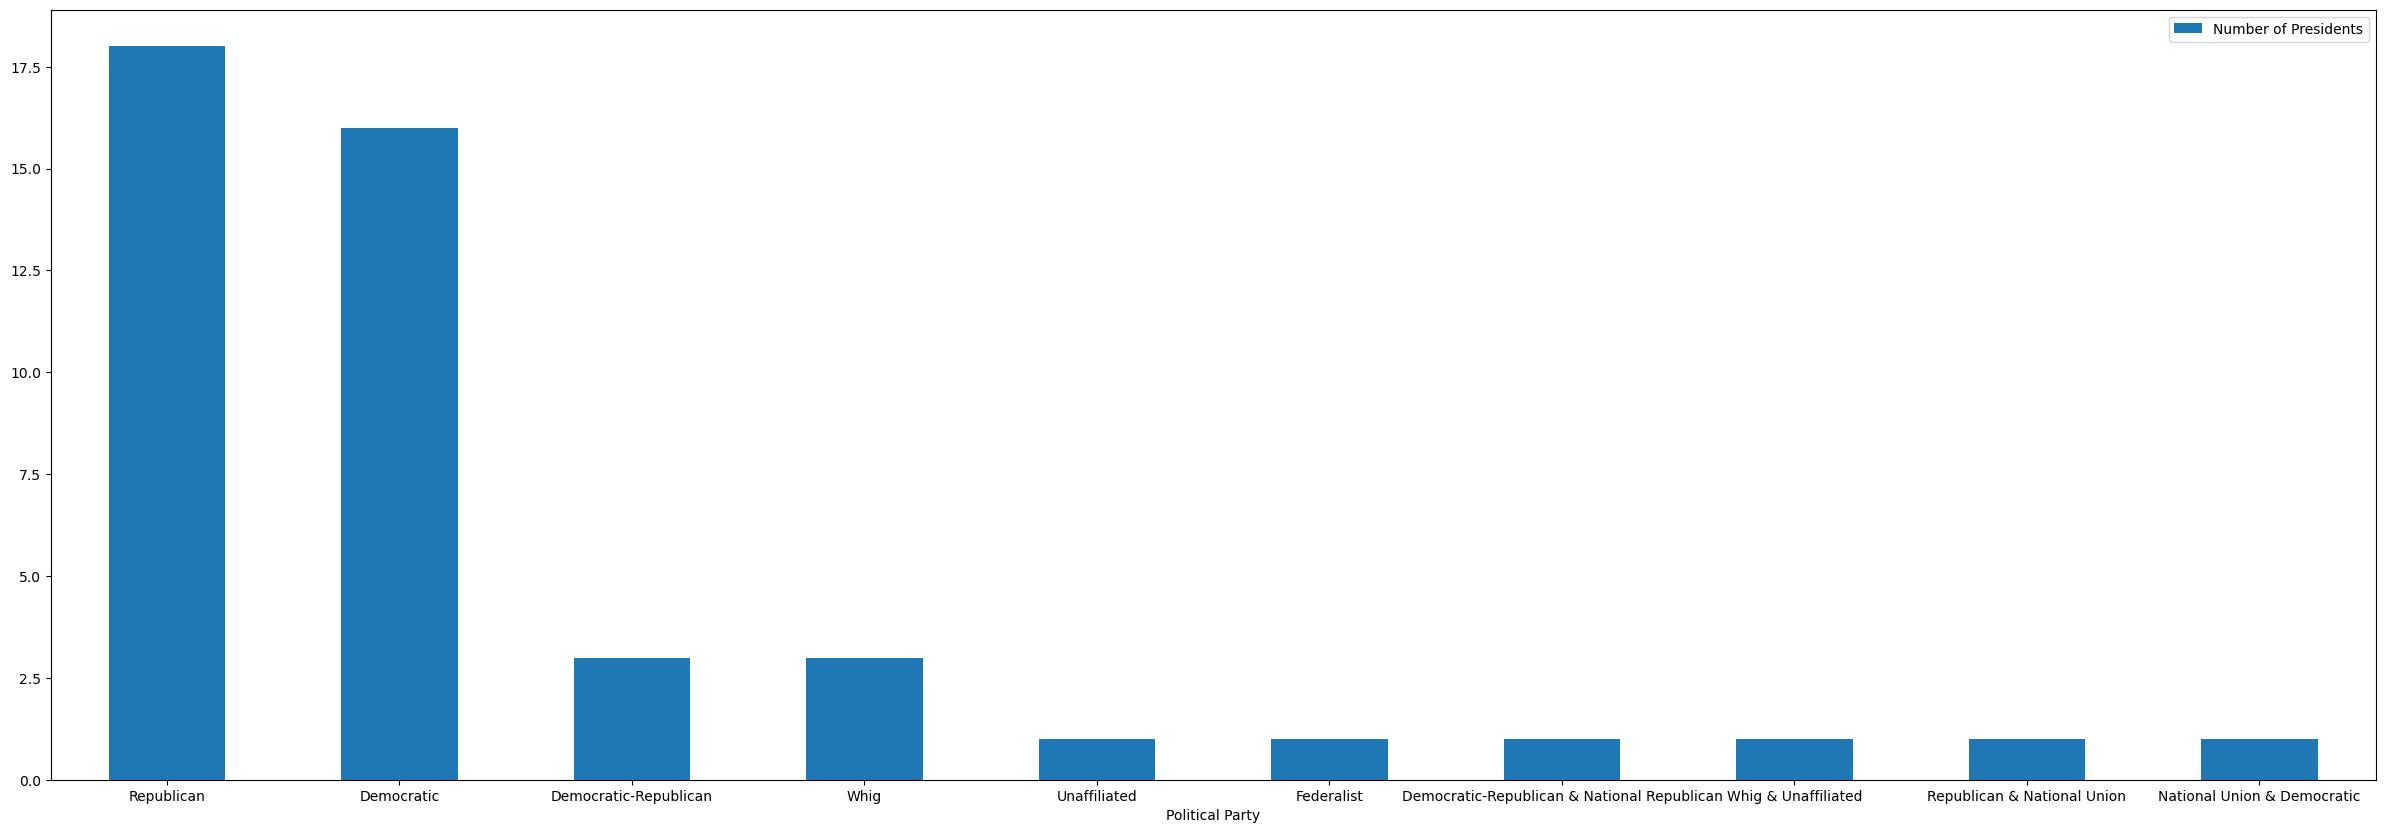

In [35]:
party_counts = df['Party'].value_counts().reset_index()

party_counts.columns = ['Political Party', 'Number of Presidents']

party_counts.plot.bar(x='Political Party', y='Number of Presidents', rot=0, figsize=(30, 10))

max_party = party_counts['Number of Presidents'].idxmax()

print(f"The party with the most presidents is the {party_counts['Political Party'].iloc[max_party]} party with " + 
      f"{party_counts['Number of Presidents'].iloc[max_party]} presidents elected")

# References

Geeks For Geeks. (2020, July 1). Find maximum values & position in columns and rows of a Dataframe in Pandas. GeeksforGeeks. https://www.geeksforgeeks.org/find-maximum-values-position-in-columns-and-rows-of-a-dataframe-in-pandas/

Mode. (2016, May 23). How to Filter Data with Boolean Indexes in Python | Python Analysis Tutorial - Mode. Mode Resources. https://mode.com/python-tutorial/python-filtering-with-boolean-indexes

Pandas. (n.d.). pandas.DataFrame.groupby — pandas 1.2.4 documentation. Pandas.pydata.org. Retrieved May 30, 2024, from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

Python. (n.d.). re — Regular expression operations. Python Documentation. Retrieved May 30, 2024, from https://docs.python.org/3/library/re.html#raw-string-notation

Saturn Cloud. (2023, December 19). How to Convert Strings in a Pandas Dataframe to a Date Data Type | Saturn Cloud Blog. Saturncloud.io. https://saturncloud.io/blog/how-to-convert-strings-in-a-pandas-data-frame-to-a-date-data-type/#:~:text=The%20to_datetime()%20function%20is

StackOverflow. (n.d.). How can I iterate over rows in a Pandas DataFrame? Stack Overflow. Retrieved May 30, 2024, from https://stackoverflow.com/questions/16476924/how-can-i-iterate-over-rows-in-a-pandas-dataframe

Vijetha. (2022, November 24). Pandas Extract Year from Datetime. Spark by {Examples}. https://sparkbyexamples.com/pandas/pandas-extract-year-from-datetime/#

In [55]:
df

,No.,Name,Party,Election,Vice President,Birth Year,Death Year,Date In,Date Out
0,1,George Washington,Unaffiliated,1788–1789 & 1792,John Adams,1732,1799,1789-04-30,1797-03-04
1,2,John Adams,Federalist,1796,Thomas Jefferson,1735,1826,1797-03-04,1801-03-04
2,3,Thomas Jefferson,Democratic-Republican,1800 & 1804,Aaron Burr & George Clinton,1743,1826,1801-03-04,1809-03-04
3,4,James Madison,Democratic-Republican,1808 & 1812,George Clinton & Elbridge Gerry,1751,1836,1809-03-04,1817-03-04
4,5,James Monroe,Democratic-Republican,1816 & 1820,Daniel D. Tompkins,1758,1831,1817-03-04,1825-03-04
5,6,John Quincy Adams,Democratic-Republican & National Republican,1824,John C. Calhoun,1767,1848,1825-03-04,1829-03-04
6,7,Andrew Jackson,Democratic,1828 & 1832,John C. Calhoun & Martin Van Buren,1767,1845,1829-03-04,1837-03-04
7,8,Martin Van Buren,Democratic,1836,Richard Mentor Johnson,1782,1862,1837-03-04,1841-03-04
8,9,William Henry Harrison,Whig,1840,John Tyler,1773,1841,1841-03-04,1841-04-04
9,10,John Tyler,Whig & Unaffiliated,–,,1790,1862,1841-04-04,1845-03-04


In [65]:


# Get current datetime
current_datetime = datetime.now()
print(current_datetime)

AttributeError: module 'datetime' has no attribute 'now'